In [1]:
from src.v4.torchdata import print_formatted_table, load_vals, unload_vals
from src.v5.problem import symbolic, sqrt
from src.v6.problem import MFunctionalSet, MFunctionalSetLeaf
from graph.matrixview import render_incidence
from graph.graphutils import default_tree, all_edges, all_variables
from graph.operators import reformulate
from graph.workflow import order_from_tree
from src.v2.tearing import dir_graph, min_arc_set_assign
from scipy import optimize
import numpy as np

### Chapter 1 thesis

## 1) Initial formulation

In [2]:
A, Pbus, Pcomms, D, h, R, C = symbolic('A', 'P_{bus}', 'P_{comms}', 'D', 'h', 'R', 'C')
D1 = MFunctionalSetLeaf(Pcomms == 483.3*A-Pbus, idvals=[0]) 
D2 = MFunctionalSetLeaf(Pbus == 10*sqrt(Pcomms), idvals=[1]) 
D3 = MFunctionalSetLeaf(R == Pcomms*D**2/h**2*0.125e6, idvals=[2]) 
D4 = MFunctionalSetLeaf(C == 2.5*D**2+12*(A+1)+0.1*Pbus, idvals=[3])
FPF_init = MFunctionalSet(D1,D2,D3,D4).subsetof(R>=1, h>=400).minimize(C)
FPF_init_MDA = FPF_init.config(elim=[
    MFunctionalSet(D1,D2).config(residuals=[D1,D2]), 
    D3, D4])

### 1.1) Design

In [3]:
f_MDF = FPF_init_MDA.build()
x0 = {"h": 400, "A": 0.05, "D": 0.1}
x0_MDA = f_MDF.analysis(load_vals(x0, f_MDF.indices, isdict=True, default=1))
for elt in FPF_init.supersets:
    fP = elt.build()
    xP = load_vals(unload_vals(x0_MDA, f_MDF.indices), fP.indices, isdict=True)
    print_formatted_table([xP], fP.indices)

P_{comms} P_{bus} A   
4.047     20.118  0.05
P_{bus} P_{comms}
20.118  4.047    
R     D   h   P_{comms}
0.032 0.1 400 4.047    
C      D   P_{bus} A   
14.637 0.1 20.118  0.05


### 2.2) Optimization
Turns out that for SLSQP, MDF with coupled solver is ill-conditioned; the gradient of the constraint with respect to A and to D becomes zero as A and D go to zero in the infeasible part of the design (R<1).

In [4]:
x0_full = {'A': 1, 'P_{bus}': 1, 'P_{comms}': 1, 'D': 1, 'h': 1, 'R': 1e-3} # Found a pretty bad error, which is if we initialize the wrong names
obj, dobj, xguess, cons, idxs, solidxs = FPF_init_MDA.build_opt(x0=x0_full)

In [5]:
xsol = optimize.minimize(obj, xguess, jac=dobj, 
                         constraints=cons, method='SLSQP', bounds=[(1e-3,1000),(1e-3,1000),(1e-3,1000)])#, options={'maxiter':20})
xsol

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 15.300930694311447
       x: [ 4.081e-02  6.705e-01  4.000e+02]
     nit: 32
     jac: [ 4.814e+01  3.352e+00  0.000e+00]
    nfev: 35
    njev: 29

## 2) Reparametrized formulation

In [6]:
D1 = MFunctionalSetLeaf(A == (Pbus+Pcomms)/483.3, idvals=[0]) 
D2 = MFunctionalSetLeaf(Pbus == 10*sqrt(Pcomms), idvals=[1]) 
D3 = MFunctionalSetLeaf(Pcomms == R*h**2/D**2*8e-6, idvals=[2])
D4 = MFunctionalSetLeaf(C == 2.5*D**2+12*(A+1)+0.1*Pbus, idvals=[4])
FPF_repar = MFunctionalSet(D1,D2,D3,D4).subsetof(R>=1, h>=400, D>=0).minimize(C)
FPF_repar_MDA = FPF_repar.config(elim=[D3, D2, D1, D4])

### 2.1) Design

In [7]:
f_MDF = FPF_repar_MDA.build()
x0 = {"h": 400, "R": 1, "D": 0.1}
x0_MDA = f_MDF.analysis(load_vals(x0, f_MDF.indices, isdict=True, default=1))
for elt in FPF_init.supersets:
    fP = elt.build()
    xP = load_vals(unload_vals(x0_MDA, f_MDF.indices), fP.indices, isdict=True)
    print_formatted_table([xP], fP.indices)

P_{comms} P_{bus} A    
128       113.137 0.499
P_{bus} P_{comms}
113.137 128      
R D   h   P_{comms}
1 0.1 400 128      
C      D   P_{bus} A    
29.326 0.1 113.137 0.499


### 2.2) Optimization

In [8]:
x0_full = {'A': 1, 'Pb': 1, 'Pc': 1, 'D': 1, 'h': 1, 'R': 1e-3}
obj, dobj, xguess, cons, idxs, solidxs = FPF_repar_MDA.build_opt(x0=x0_full)

In [9]:
xsol = optimize.minimize(obj, xguess, jac=dobj, 
                         constraints=cons, method='SLSQP')
xsol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 15.300931267672876
       x: [ 6.703e-01  1.000e+00  4.000e+02]
     nit: 9
     jac: [-3.599e-03  1.124e+00  5.621e-03]
    nfev: 12
    njev: 9

In [10]:
idxrev = {var.item():key for key,var in idxs.items()}
xsoldict = {str(idxrev[key.item()]): xsol.x[idx] for idx,key in enumerate(solidxs)}
xidxed = load_vals(xsoldict, f_MDF.indices, isdict=True, default=1)
xsolvalall = f_MDF.analysis(xidxed)
print_formatted_table([xsolvalall], idxs)

R h   D    C      P_{bus} A     P_{comms}
1 400 0.67 15.301 16.88   0.041 2.849    


## 3) Structure information

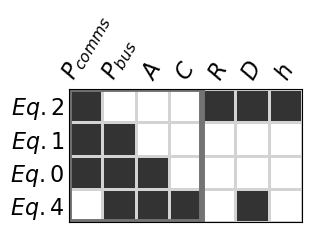

In [96]:
idxrev = {var.item():key for key,var in f_MDF.indices.items()}
in_outs = {elt.supersets[0][0]: elt.build(indices=f_MDF.indices).analysis.structure for elt in FPF_repar_MDA.elim}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
sorted_keys = sorted(Ein.keys())
tree = default_tree(Ein.keys())
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((3,3)),diagonalgray=False);

In [4]:
graph_edges_minassign = all_edges(*edges)
varidxs = all_variables(*edges)
eqnidxs = list(edges[1].keys())
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [5]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_output=['D'])
outset_initial = {comp: var[0] for comp,var in edges[1].items()}
outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-13


In [6]:
str2symb = {str(key):key for key in indices.keys()}
outset_symb = {key:symbolic(str2symb[val])[0] for key,val in outset_opt.items()}
edges_new, tree_new = reformulate(edges, tree, outset_initial, outset_opt, root_solver_name=1)
workflow_order = order_from_tree(tree_new[0], tree_new[1], Eout=edges_new[1])

### 2) Reconfigure original formulation based on presolver or manual specify

In [7]:
FPFr1 = FPF.reconfigure(outset_symb).config_from_order([{2}, {1}, {0}])
FPFr2 = FPF.reconfigure(outset_symb).config_from_workflow(workflow_order)
FPF_MDF = FPF.config(elim=[D3, D2, D1]) # Manual configuration
formulation_of_choice = FPFr2